In [234]:
import os

import numpy as np
import pandas as pd

import networkx as nx
from networkx.drawing.nx_pylab import draw, draw_networkx_nodes, draw_networkx_edges
from networkx.classes.function import set_node_attributes
from pyvis.network import Network

import matplotlib
import mpld3
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d

import statsmodels.api as sm
import seaborn as sns

In [2]:
poll_data = pd.read_excel("docs/encrypted.xlsx").drop("Unnamed: 0", axis=1).fillna("")

### hálózat

#### irányított

In [3]:
G = nx.DiGraph()

In [4]:
G.add_nodes_from(poll_data["ID"].unique())

In [5]:
edges = np.concatenate(
    poll_data.apply(
        lambda r: [
            [r["ID"], r[c]]
            for c in poll_data.columns
            if ("Kontakt" in c) and ("szám" not in c) and (r[c] != 0)
        ],
        axis=1,
    )
)

In [6]:
G.add_edges_from(edges)

In [7]:
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 93
Number of edges: 1258
Average in degree:  13.5269
Average out degree:  13.5269


#### irányítatlan

In [8]:
edges_df = (
    pd.DataFrame(edges)
    .rename(columns={0: "from", 1: "to"})
    .merge(
        pd.DataFrame(
            np.array(
                [
                    np.sort(e)
                    for e in G.edges()
                    if ((e[::-1] in G.edges()) and (e[0] != e[1])) or ()
                ]
            )
        )
        .drop_duplicates()
        .reset_index(drop=True),
        how="right",
        left_on=["from", "to"],
        right_on=[0, 1],
    )
    .drop([0, 1], axis=1)
    .reset_index(drop=True)
)

In [9]:
G_undir = nx.Graph()

In [10]:
G_undir.add_nodes_from(poll_data.reset_index()["ID"].unique())

In [11]:
G_undir.add_edges_from(edges_df[["from", "to"]].values)

In [12]:
print(nx.info(G_undir))

Name: 
Type: Graph
Number of nodes: 88
Number of edges: 406
Average degree:   9.2273


### plusz feature-ök

#### beszédtémák megoszlása

In [13]:
topics = [c for c in poll_data.columns if "téma" in c]

In [14]:
edges_df = (
    edges_df.merge(
        poll_data[["ID"] + topics],
        how="left",
        left_on="from",
        right_on="ID",
    )
    .rename(columns={c: c.replace("-téma", "_from") for c in topics})
    .drop("ID", axis=1)
    .merge(
        poll_data[["ID"] + topics], how="left", left_on="to", right_on="ID"
    )
    .rename(columns={c: c.replace("-téma", "_to") for c in topics})
    .drop("ID", axis=1)
    .reset_index(drop=True)
)

In [15]:
def topic_ranker(row):

    return topics[
        np.argmax(
            [
                np.nanmean([row[c.replace("-téma", s)] for s in ["_from", "_to"]])
                for c in topics
            ]
        )
    ]

In [16]:
edges_df["Domináns téma"] = edges_df.apply(topic_ranker, axis=1).values

In [22]:
edges_df.to_excel("edges.xlsx")

#### kontaktok

In [17]:
poll_data["out_degree"] = poll_data["ID"].apply(lambda n: G.out_degree(n))
poll_data["in_degree"] = poll_data["ID"].apply(lambda n: G.in_degree(n))
poll_data["mut_degree"] = poll_data["ID"].apply(lambda n: G_undir.degree(n))

In [52]:
poll_data.to_excel("poll_data.xlsx")

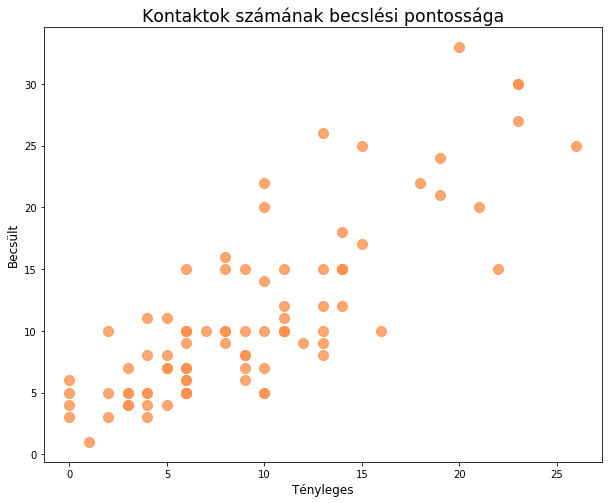

In [114]:
fig = plt.figure(figsize=(10, 8))

plt.scatter(
    poll_data["mut_degree"],
    poll_data["Kontaktok becsült száma"],
    c="#ff914d",
    s=100,
    alpha=0.8,
)

plt.xlabel("Tényleges", fontsize="large")
plt.ylabel("Becsült", fontsize="large")

title = "Kontaktok számának becslési pontossága"
plt.title(title, fontsize="xx-large")
mpld3.save_html(fig, "docs/{}.html".format("_".join(title.split(" "))))

In [20]:
bins = np.linspace(0, poll_data["mut_degree"].max(), 11)

In [21]:
def to_lines(attr):

    return [
        pd.cut(poll_data.loc[poll_data[attr] == i, "mut_degree"], bins=bins)
        .value_counts(normalize=True)
        .sort_index()
        .values
        for i in [0, 1]
    ]

In [116]:
def smooth_plot(lines, labels, title, bins=bins):

    x = np.linspace(bins[1], bins[-1], 50)
    smooth_lines = [interp1d(bins[1:], l, kind="cubic")(x) for l in lines]

    fig = plt.figure(figsize=(12, 6))

    plt.plot(x, smooth_lines[0], "#ff914d", label=labels[0], lw=5)
    plt.plot(x, smooth_lines[1], "#38b6ff", label=labels[1], lw=5)
    plt.legend()

    plt.title(title, fontsize="xx-large")
    plt.xlabel("Kontaktok száma", fontsize="large")
    plt.ylabel("Relatív gyakoriság", fontsize="large")
    
    mpld3.save_html(fig, "docs/{}.html".format("_".join(title.split(" "))))

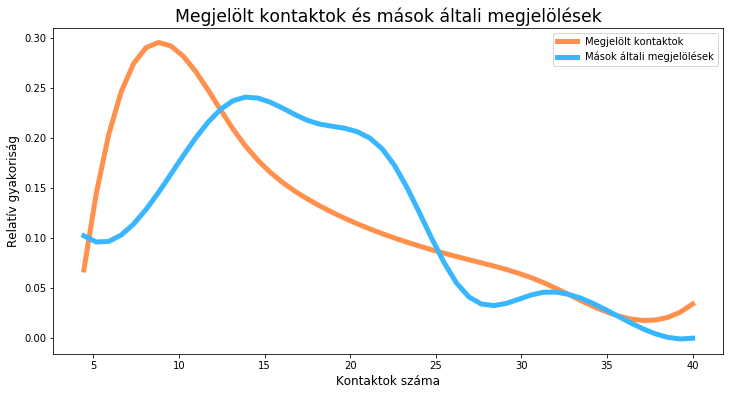

In [117]:
smooth_plot(
    [
        pd.cut(
            poll_data["{}_degree".format(d)],
            bins=np.linspace(0, poll_data["out_degree"].max(), 10),
        )
        .value_counts(normalize=True)
        .sort_index()
        .values
        for d in ["out", "in"]
    ],
    ["Megjelölt kontaktok", "Mások általi megjelölések"],
    "Megjelölt kontaktok és mások általi megjelölések",
    np.linspace(0, poll_data["out_degree"].max(), 10)
)

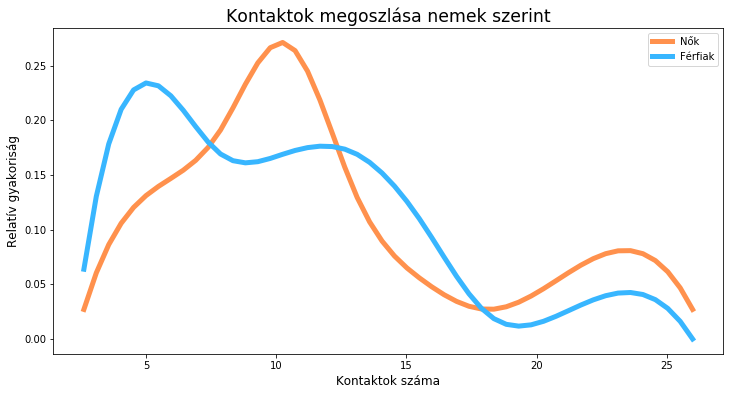

In [118]:
smooth_plot(to_lines("Nem"), ["Nők", "Férfiak"], "Kontaktok megoszlása nemek szerint")

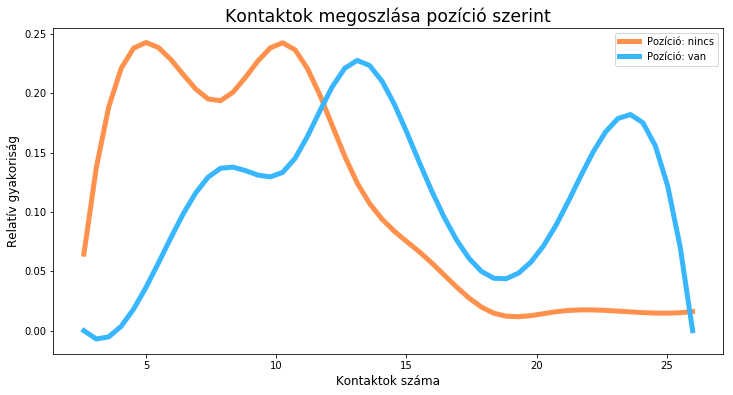

In [119]:
smooth_plot(
    to_lines("Pozíció"),
    ["Pozíció: nincs", "Pozíció: van"],
    "Kontaktok megoszlása pozíció szerint",
)

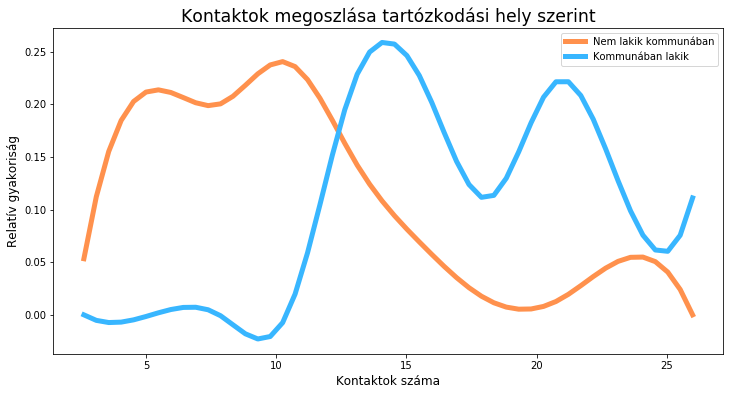

In [120]:
smooth_plot(
    to_lines("Kommuna"),
    ["Nem lakik kommunában", "Kommunában lakik"],
    "Kontaktok megoszlása tartózkodási hely szerint",
)

#### platformok népszerűsége

In [28]:
platform_popularity = dict(
    poll_data[[c for c in poll_data.columns if "Platform" in c]]
    .unstack()
    .loc[lambda s: s != ""]
    .value_counts()
)

In [149]:
def pie(data_dict, title, colors):
    
    fig = plt.figure(figsize = (10, 8))

    plt.pie(
        data_dict.values(),
        labels=data_dict.keys(),
        colors=colors,
        explode=[0.05,0.05,0.05,0.05][:len(data_dict)],
        textprops={"color": "#ffffff"}
    )

    plt.legend(loc=4, fontsize="large")

    plt.title(title, fontsize="xx-large")
    
    mpld3.save_html(fig, "docs/{}.html".format("_".join(title.split(" "))))

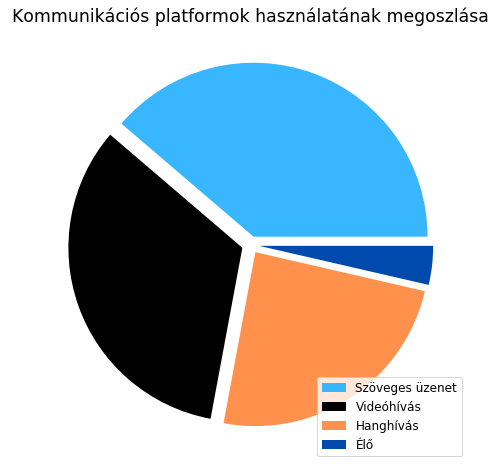

In [150]:
pie(
    platform_popularity,
    "Kommunikációs platformok használatának megoszlása",
    colors=["#38b6ff", "#000000", "#ff914d", "#004aad"],
)

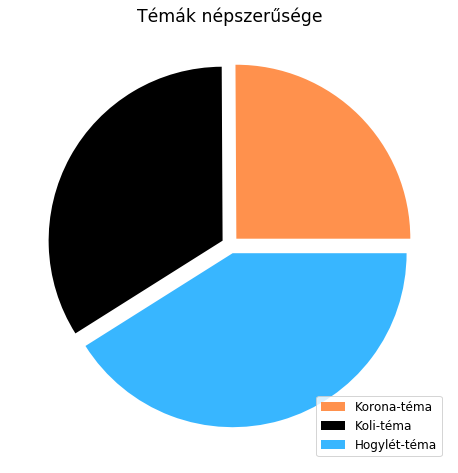

In [151]:
pie(
    {c: poll_data[c].mean().round(2) for c in topics},
    "Témák népszerűsége",
    colors=["#ff914d", "#000000", "#38b6ff"],
)

### vizualizáció

In [140]:
topics = {
    "Korona-téma": {"c": "#ff914d", "w": 2},
    "Koli-téma": {"c": "#9eff53", "w": 2},
    "Hogylét-téma": {"c": "#38b6ff", "w": 1},
}

In [104]:
def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

In [105]:
r = 1

In [109]:
node_df = (
    (
        pd.DataFrame(
            pd.concat(
                [
                    edges_df[[c, "Domináns téma"]].rename(columns={c: "node"})
                    for c in ["from", "to"]
                ]
            )
            .reset_index(drop=True)
            .groupby("node")
            .apply(lambda df: df["Domináns téma"].value_counts().index[0])
        ).merge(
            poll_data[["ID", "mut_degree", "Pozíció", "Nem"]], how="left", left_index=True, right_on="ID"
        )
    )
    .rename(columns={0: "topic", "mut_degree": "degree"})
    .set_index("ID")
    .sort_values(["topic", "degree"])
    .assign(
        pos=lambda df: [
            pol2cart(r, _p) for _p in np.linspace(0, 2 * np.pi, df.shape[0])
        ]
    )
)

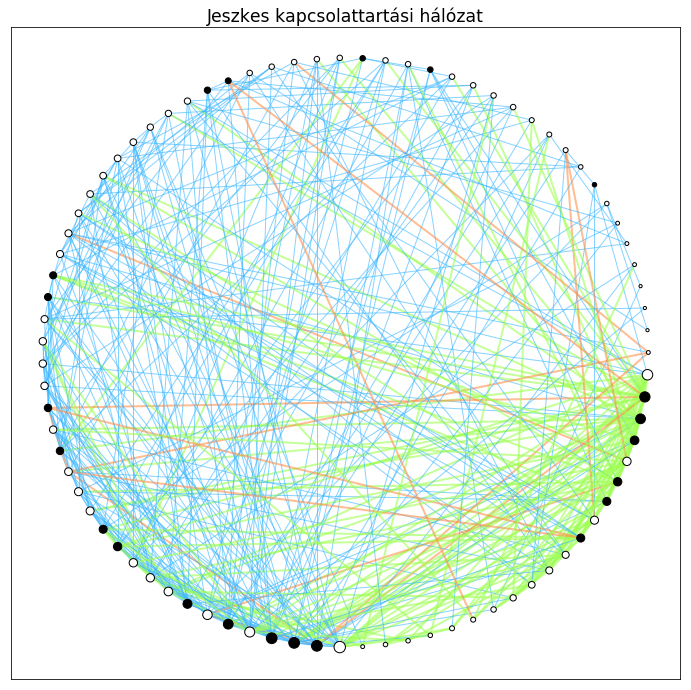

In [148]:
fig, ax = plt.subplots(figsize=(12, 12))

draw_networkx_nodes(
    G,
    dict(node_df["pos"]),
    ax=ax,
    nodelist=node_df.index.values,
    node_size=node_df["degree"].values * 5,
    node_color=node_df["Pozíció"].apply(lambda x: "#000000" if x else "#ffffff").values,
    edgecolors="#000000"
)

draw_networkx_edges(
    G,
    dict(node_df["pos"]),
    edgelist=[tuple(arr) for arr in edges_df[["from", "to"]].values],
    edge_color=edges_df["Domináns téma"].apply(lambda x: topics[x]["c"]).values,
    arrows=False,
    alpha=0.6,
    width=edges_df["Domináns téma"].apply(lambda x: topics[x]["w"]).values,
)

title = "Jeszkes kapcsolattartási hálózat"
plt.title(title, fontsize="xx-large")
mpld3.save_html(fig, "docs/{}.html".format("_".join(title.split(" "))))

[hex color codes](https://www.color-hex.com/color-palettes/)

### Kontakt valószínűség becslés

In [196]:
all_edges_df = pd.DataFrame(edges).rename(columns={0:"from", 1:"to"})

In [204]:
adjacency = (
    pd.DataFrame(
        np.concatenate(
            [
                [
                    np.sort([n, k])
                    for k in edges_df[["from", "to"]].unstack().sort_values().unique()
                    if k != n
                ]
                for n in edges_df[["from", "to"]].unstack().sort_values().unique()
            ]
        )
    )
    .drop_duplicates()
    .reset_index(drop=True)
    .rename(columns={n: "node_{}".format(n) for n in range(2)})
    .merge(
        edges_df[["from", "to"]],
        how="left",
        left_on=["node_0", "node_1"],
        right_on=["from", "to"],
    )
    .merge(
        edges_df[["from", "to"]],
        how="left",
        left_on=["node_0", "node_1"],
        right_on=["to", "from"],
    )
    .assign(edge=lambda df: (~df["from_x"].isna() | ~df["from_y"].isna()).astype(int))
    .drop(["from_x", "to_x", "from_y", "to_y"], axis=1)
    .merge(
        poll_data[["ID", "Nem", "Egyetem", "Kar", "Szint", "Pozíció", "Kommuna"]],
        how="left",
        left_on="node_0",
        right_on="ID",
    )
    .merge(
        poll_data[["ID", "Nem", "Egyetem", "Kar", "Szint", "Pozíció", "Kommuna"]],
        how="left",
        left_on="node_1",
        right_on="ID",
    )
)

In [205]:
for attr in ["Nem", "Egyetem", "Kar", "Szint"]:
    adjacency[attr] = (adjacency["{}_x".format(attr)] == adjacency["{}_y".format(attr)]).astype(int)

In [206]:
adjacency["Pozíció"] = adjacency["Pozíció_x"] + adjacency["Pozíció_y"]

In [207]:
adjacency["Kommuna"] = adjacency["Kommuna_x"] * adjacency["Kommuna_y"]

In [208]:
adjacency = adjacency.drop(
    [c for c in adjacency.columns if ("_x" in c) or ("_y" in c)], axis=1
)

In [225]:
def fit_logit(exog):

    logit = sm.Logit(adjacency["edge"], adjacency[exog].assign(c=1))

    results = logit.fit()
    print(results.summary())

In [229]:
X = ["Nem", "Egyetem", "Kar", "Szint", "Pozíció", "Kommuna"]

In [228]:
fit_logit(X)

Optimization terminated successfully.
         Current function value: 0.341136
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   edge   No. Observations:                 3486
Model:                          Logit   Df Residuals:                     3479
Method:                           MLE   Df Model:                            6
Date:                Thu, 23 Apr 2020   Pseudo R-squ.:                 0.05194
Time:                        21:33:00   Log-Likelihood:                -1189.2
converged:                       True   LL-Null:                       -1254.3
Covariance Type:            nonrobust   LLR p-value:                 1.115e-25
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Nem           -0.0579      0.109     -0.533      0.594      -0.271       0.155
Egyetem        0.1189      0.

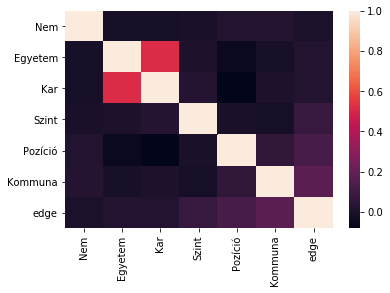

In [231]:
sns.heatmap(
    pd.DataFrame(
        np.corrcoef([adjacency[x] for x in X + ["edge"]]),
        columns=X + ["edge"],
        index=X + ["edge"],
    )
)